#  <center> Speech Emotion Recognition <center>

## Importing Libraries

In [1]:
!apt-get update
!apt-get install -y libsndfile1

Get:1 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [1231 B]
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease              
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Err:1 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease            
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY C0BA5CE6DC6315A3
Err:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
  Certificate verification failed: The certificate is NOT trusted. The certificate issuer is unknown.  Could not handshake: Error in the certificate verification. [IP: 23.212.62.149 443]
Get:7 http://packages.cloud.google.com/apt cloud-sdk-bionic InRelease [1646 B] 
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease                        
Err:6 https://

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music
# It can be used to extract the data from the audio files
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio
from IPython.display import display
# to display progress bar when running loops
from tqdm import tqdm

import keras
from keras import losses, models, optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import (
    Dense,
    Embedding,
    LSTM,
    Conv1D,
    MaxPooling1D,
    AveragePooling1D,
    Convolution2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    GlobalMaxPool2D,
    MaxPool2D,
    concatenate,
    Activation,
    Input,
    Flatten,
    Dropout,
    BatchNormalization,
)
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.utils import np_utils, to_categorical
from keras.callbacks import (
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    TensorBoard,
    ReduceLROnPlateau,
)
from keras.activations import relu, softmax

import pickle

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


Using TensorFlow backend.


## Data Preparation

Creating dataframe with emotions and audio file paths from all 4 data sources

In [3]:
# paths for data
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

###  <center> 1. RAVDESS Dataset <center>
Filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Example audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [4]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
file_gender = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split(".")[0]
        part = part.split("-")
        # third part in each file represents the emotion associated to that file
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + "/" + file)
        file_gender.append(int(part[6]))

data_dict = {
    "Emotions": file_emotion,
    "Gender": file_gender,
    "Path": file_path
}

ravdess_df = pd.DataFrame(data_dict)

# changing integers to actual emotions
ravdess_df.Emotions.replace(
    {
        1: "neutral",
        2: "calm",
        3: "happy",
        4: "sad",
        5: "angry",
        6: "fear",
        7: "disgust",
        8: "surprise",
    },
    inplace=True,
)
ravdess_df["Gender"] = ravdess_df["Gender"].apply(
    lambda x: "male" if x % 2 != 0 else "female"
)
ravdess_df.head()

Emotions  Gender                                               Path
0  surprise  female  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  female  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  female  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  female  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  female  /kaggle/input/ravdess-emotional-speech-audio/a...

In [5]:
ravdess_df["Emotions"].value_counts()

happy       192
calm        192
sad         192
disgust     192
fear        192
angry       192
surprise    192
neutral      96
Name: Emotions, dtype: int64

In [6]:
ravdess_df["Gender"].value_counts()

male      720
female    720
Name: Gender, dtype: int64

### <center>2. CREMA-D Dataset</center>

CREMA-D dataset has a wide variety of speakers with different ethnicities and age groups.

The female speakers are identified by the certain codes in the first part of the file name. These have been hard coded.

In [7]:
crema_directory_list = os.listdir(Crema)

gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in crema_directory_list: 
    part = i.split('_')
    
    if int(part[0]) in female:
        gender.append('female')
    else:
        gender.append('male')
        
    if part[2] == 'SAD':
        emotion.append('sad')
    elif part[2] == 'ANG':
        emotion.append('angry')
    elif part[2] == 'DIS':
        emotion.append('disgust')
    elif part[2] == 'FEA':
        emotion.append('fear')
    elif part[2] == 'HAP':
        emotion.append('happy')
    elif part[2] == 'NEU':
        emotion.append('neutral')
    else:
        emotion.append('Unknown')
    
    path.append(Crema + i)

data_dict = {
    "Emotions": emotion,
    "Gender": gender,
    "Path": path
}

crema_df = pd.DataFrame(data_dict)
crema_df.head()

Emotions  Gender                                               Path
0  disgust  female  /kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1    happy  female  /kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2    happy  female  /kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3  disgust    male  /kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4  disgust    male  /kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav

In [8]:
crema_df["Emotions"].value_counts()

disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: Emotions, dtype: int64

In [9]:
crema_df["Gender"].value_counts()

male      3930
female    3512
Name: Gender, dtype: int64

###  <center> 3. TESS dataset <center>

TESS dataset contains only female voices. There are 2 speakers, one old and one young female.

In [10]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

data_dict = {
    "Emotions": file_emotion,
    "Gender": ["female"] * len(file_emotion),
    "Path": file_path
}

tess_df = pd.DataFrame(data_dict)

tess_df.head()

Emotions  Gender                                               Path
0     fear  female  /kaggle/input/toronto-emotional-speech-set-tes...
1     fear  female  /kaggle/input/toronto-emotional-speech-set-tes...
2     fear  female  /kaggle/input/toronto-emotional-speech-set-tes...
3     fear  female  /kaggle/input/toronto-emotional-speech-set-tes...
4     fear  female  /kaggle/input/toronto-emotional-speech-set-tes...

In [11]:
tess_df["Emotions"].value_counts()

surprise    400
happy       400
neutral     400
sad         400
disgust     400
fear        400
angry       400
Name: Emotions, dtype: int64

In [12]:
tess_df["Gender"].value_counts()

female    2800
Name: Gender, dtype: int64

###  <center> 4. SAVEE dataset <center>
The prefix letters in the audio file name describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

This dataset contains only male speakers. The first 2 letters of the audio files contain the initials of the speaker. There are 4 speakers in total.

In [13]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

data_dict = {
    "Emotions": file_emotion,
    "Gender": ["male"] * len(file_emotion),
    "Path": file_path
}

savee_df = pd.DataFrame(data_dict)
savee_df.head()

Emotions Gender                                               Path
0    happy   male  /kaggle/input/surrey-audiovisual-expressed-emo...
1     fear   male  /kaggle/input/surrey-audiovisual-expressed-emo...
2    happy   male  /kaggle/input/surrey-audiovisual-expressed-emo...
3  disgust   male  /kaggle/input/surrey-audiovisual-expressed-emo...
4    angry   male  /kaggle/input/surrey-audiovisual-expressed-emo...

In [14]:
savee_df["Emotions"].value_counts()

neutral     120
disgust      60
sad          60
fear         60
angry        60
surprise     60
happy        60
Name: Emotions, dtype: int64

In [15]:
savee_df["Gender"].value_counts()

male    480
Name: Gender, dtype: int64

### <center>Combined DataFrame</center>

In [16]:
# creating Dataframe using all the 4 dataframes
data_path = pd.concat([ravdess_df, crema_df, tess_df, savee_df], axis = 0)
data_path.reset_index(drop=True, inplace=True)
data_path.to_csv("data_path.csv",index=False)
data_path

Emotions  Gender                                               Path
0      surprise  female  /kaggle/input/ravdess-emotional-speech-audio/a...
1       neutral  female  /kaggle/input/ravdess-emotional-speech-audio/a...
2       disgust  female  /kaggle/input/ravdess-emotional-speech-audio/a...
3       disgust  female  /kaggle/input/ravdess-emotional-speech-audio/a...
4       neutral  female  /kaggle/input/ravdess-emotional-speech-audio/a...
...         ...     ...                                                ...
12157  surprise    male  /kaggle/input/surrey-audiovisual-expressed-emo...
12158   neutral    male  /kaggle/input/surrey-audiovisual-expressed-emo...
12159   neutral    male  /kaggle/input/surrey-audiovisual-expressed-emo...
12160     angry    male  /kaggle/input/surrey-audiovisual-expressed-emo...
12161     happy    male  /kaggle/input/surrey-audiovisual-expressed-emo...

[12162 rows x 3 columns]

## Data Visualisation and Exploration

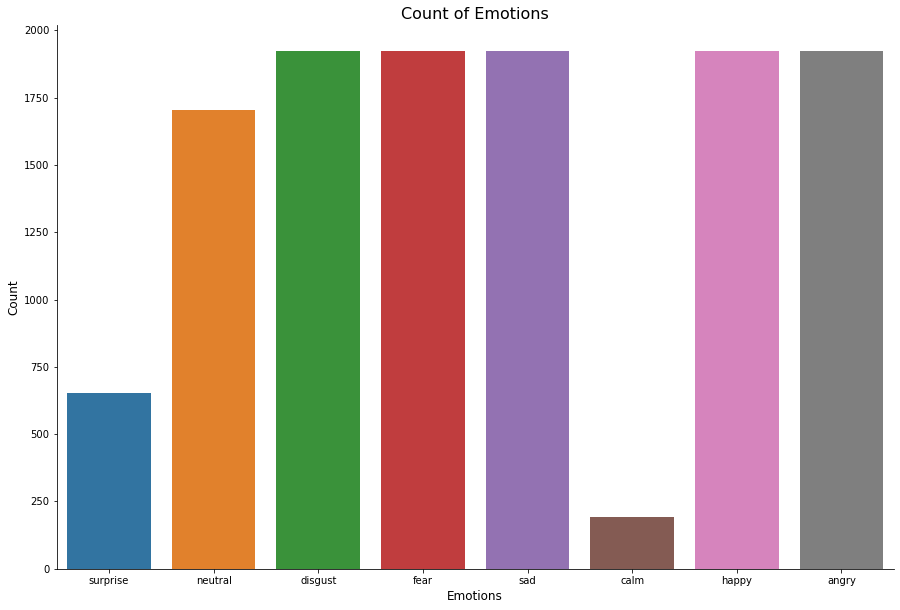

In [17]:
plt.figure(figsize=(15, 10))
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

In [18]:
data_path["Gender"].value_counts()

female    7032
male      5130
Name: Gender, dtype: int64

Functions to create waveplots and spectograms for the audio signals
* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [19]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(20, 5))
    plt.title("Waveplot for audio with {} emotion".format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(20, 5))
    plt.title("Spectrogram for audio with {} emotion".format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis="time", y_axis="hz")
    plt.colorbar()

def create_MFCC_plot(data, sr, e):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    plt.figure(figsize=(20, 5))
    plt.title("Spectrogram of MFCC for audio with {} emotion".format(e), size=15)
    librosa.display.specshow(mfcc, x_axis="time")
    plt.ylabel("MFCC")
    plt.colorbar()


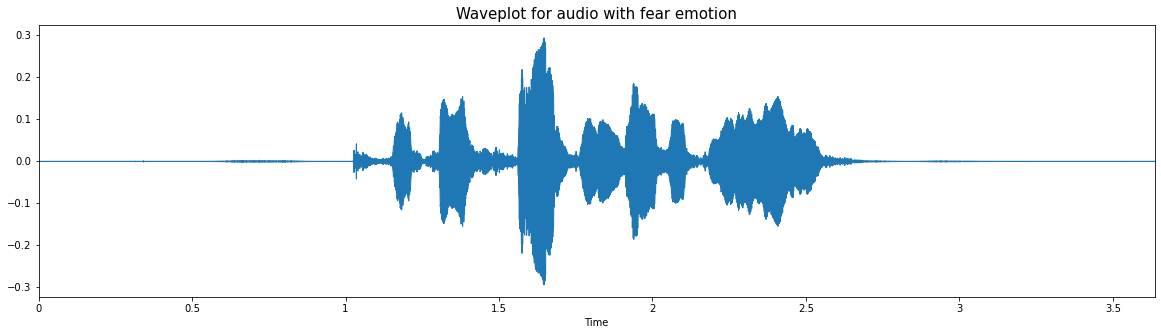

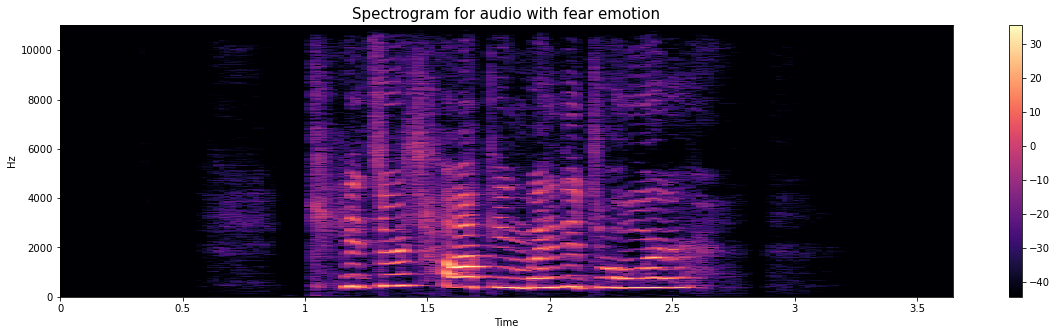

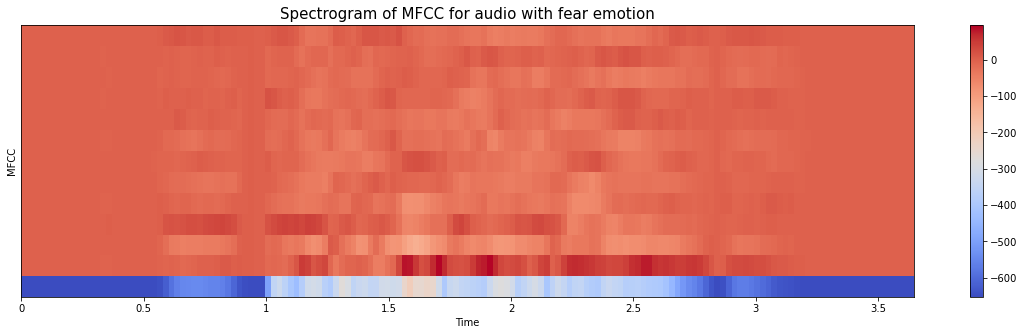

In [20]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_MFCC_plot(data, sampling_rate, emotion)
Audio(path)

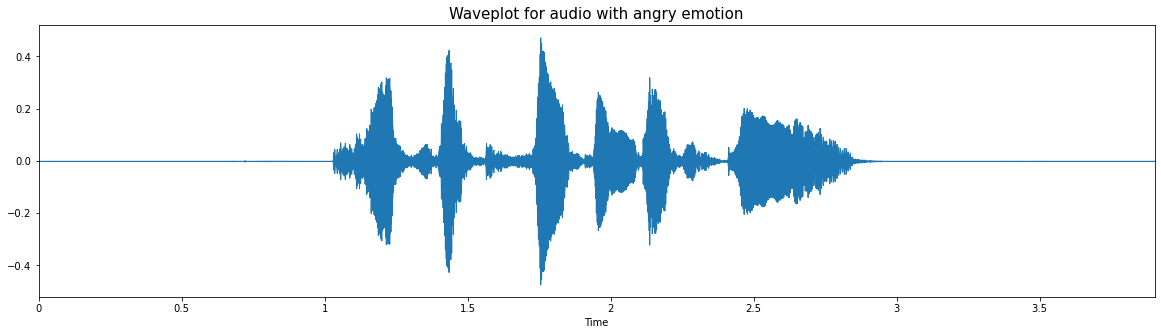

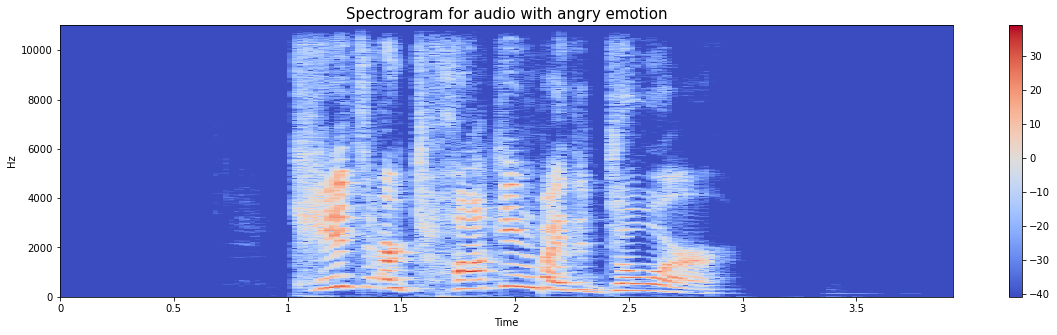

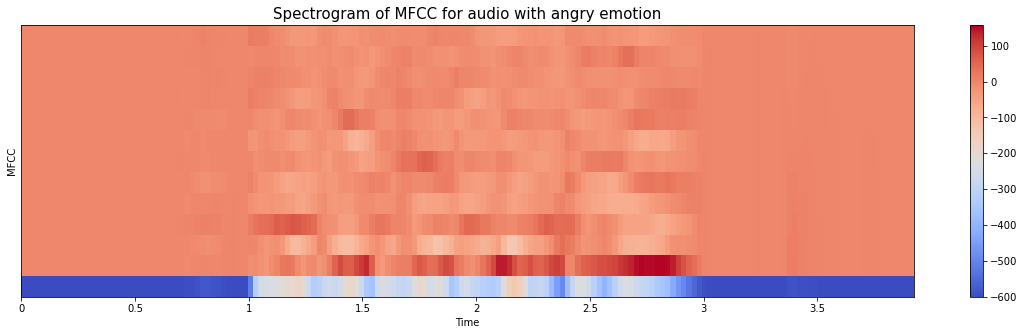

In [21]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_MFCC_plot(data, sampling_rate, emotion)
Audio(path)

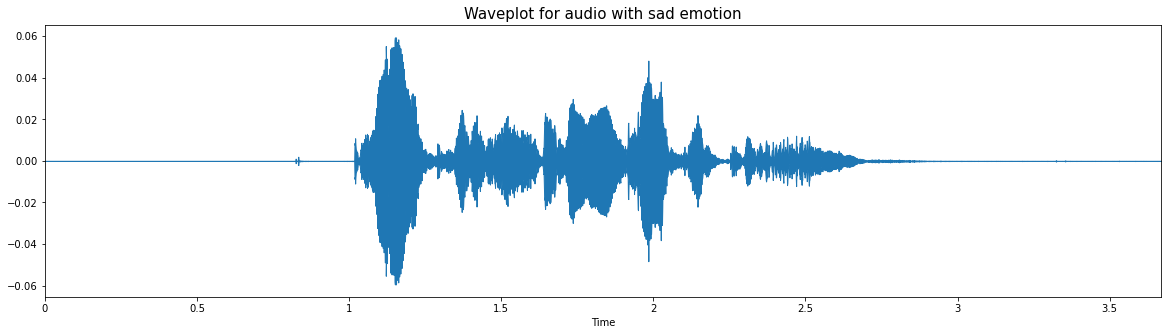

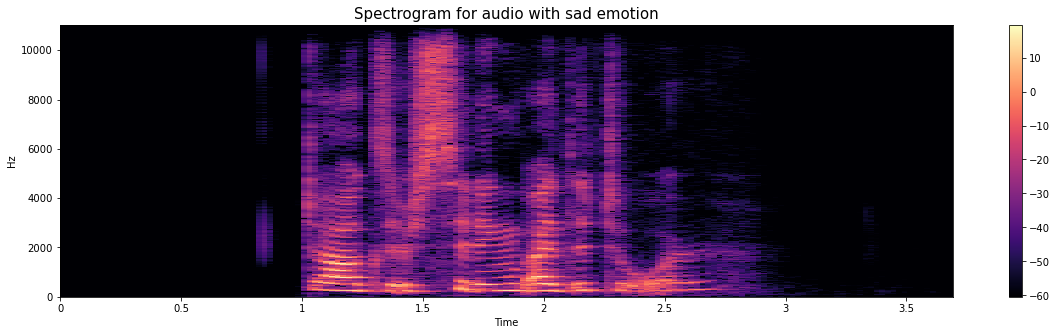

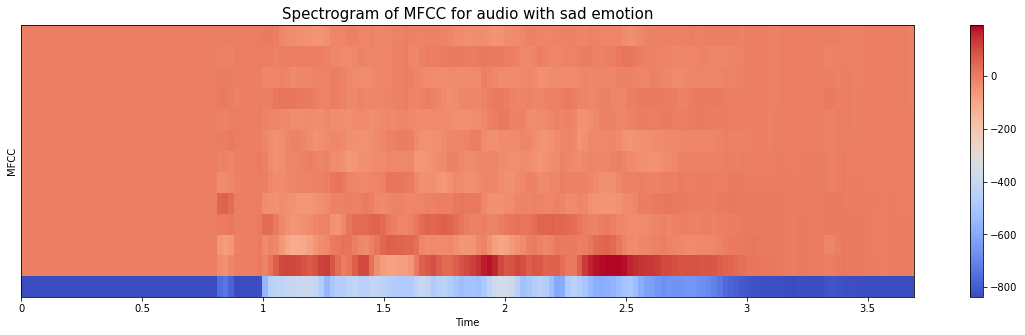

In [22]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_MFCC_plot(data, sampling_rate, emotion)
Audio(path)

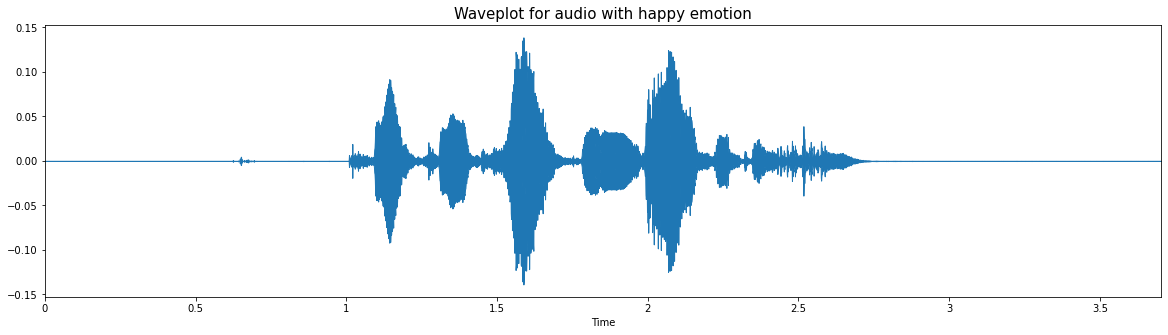

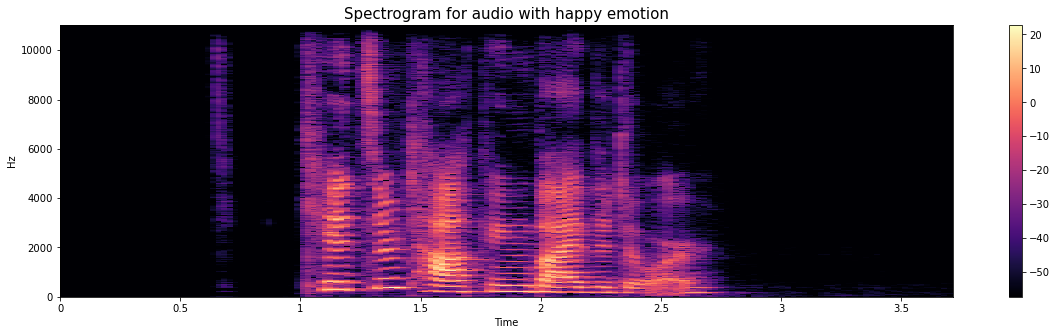

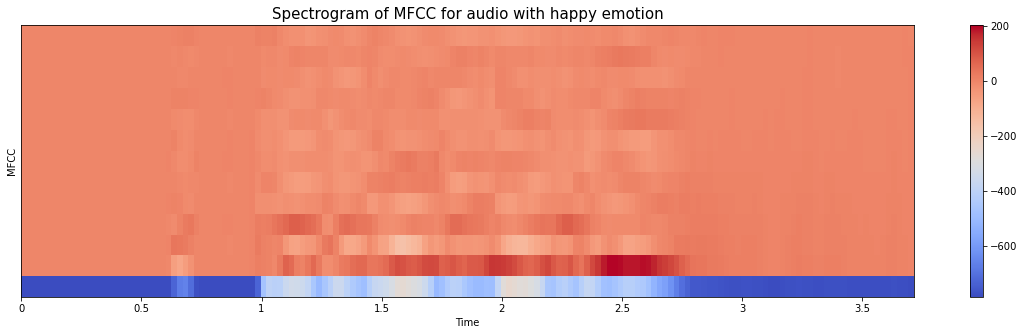

In [23]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_MFCC_plot(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

Data augmentation creates new synthetic samples by applying small perturbations to the initial training set.
- For audio, this involves techniques like noise injection, time shifting, pitch modification, and speed alteration.
- The goal is to make the model robust to these variations and improve generalization.
- To be effective, the applied perturbations must preserve the original label.
- In image data, augmentation includes shifting, zooming, and rotating.

Applying some popular augmentation techniques for voice data :

In [24]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data


def stretch(data, rate=0.8):

    return librosa.effects.time_stretch(data, rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)

    return np.roll(data, shift_range)


def pitch(data, sampling_rate, pitch_factor=0.2):

    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


def speedNpitch(data):

    length_change = np.random.uniform(low=0.8, high=1)
    speed_fac = 1.2 / length_change
    tmp = np.interp(np.arange(0, len(data), speed_fac), np.arange(0, len(data)), data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]

    return data


# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)


#### 1. Simple Audio

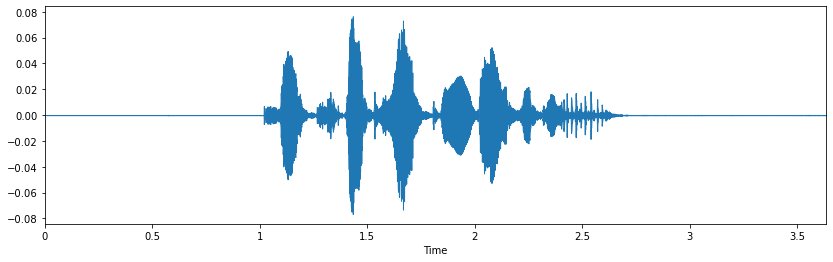

In [25]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

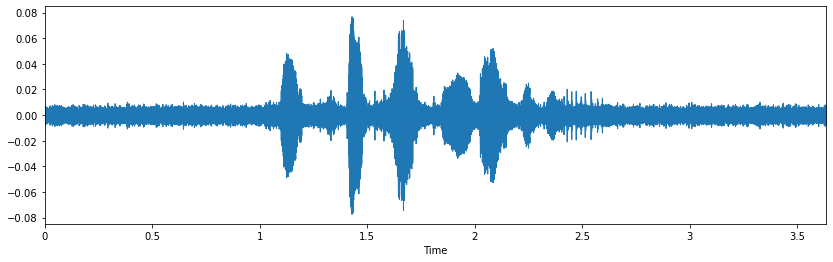

In [26]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

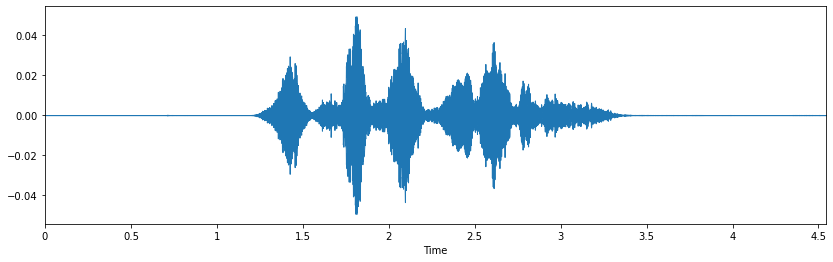

In [27]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

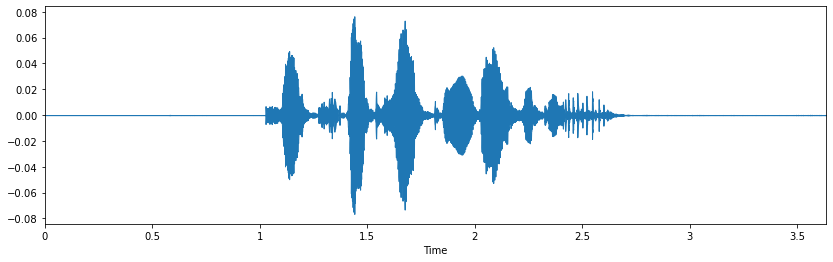

In [28]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

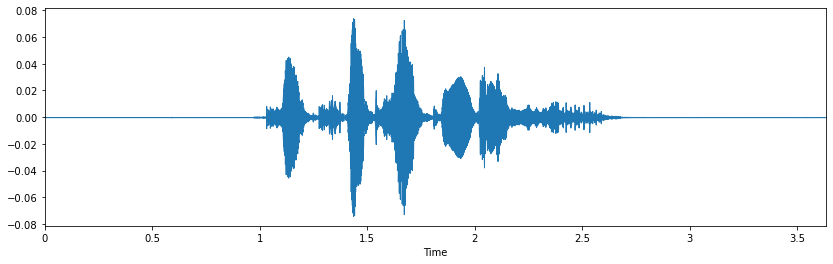

In [29]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Using noise, stretching(ie. changing speed) and some pitching to augment our actual data.

## Feature Extraction

Extracting relevant features from the voice data is crucial as audio cannot be directly understood by the models. Hence, we need to extract features which the model can interpret and use to predict the emotion.

The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

Utilising blog by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) to determine which features to extract and use.

The relevant features from the blog which can be extracted are :
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.

In this project, a detailed feature selection process is not performed to identify the most relevant features for the dataset. Instead, five key features are extracted for model training:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [30]:
def extract_features(data):
    
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=30).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


def get_features(path):
    
    # duration and offset are used to take care of the no audio in start and the ending of each audio file
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6, sr=44100)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))  # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))  # stacking vertically

    return result


In [31]:
X, Y = [], []
f=1

for path, emotion, gender in tqdm(zip(data_path.Path, data_path.Emotions, data_path.Gender)):
    feature = get_features(path)
    for ele in feature:
        # adding gender to the features before adding the features to list of features for other tracks
        X.append(np.append(ele,gender))
        Y.append(emotion)


12162it [1:10:55,  2.86it/s]


In [32]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [ ]:
Features = pd.DataFrame(X)
Features.rename(columns={len(X[0]) - 1 : "gender"}, inplace=True)

Features['labels'] = Y

Features

0                   1                   2  \
0       0.22365541811342593  0.6891831755638123  0.6623430848121643   
1        0.3150679976851852  0.7553405165672302  0.7704312801361084   
2       0.14688585069444443  0.6847826838493347  0.6656821966171265   
3        0.2302585177951389  0.6517950892448425  0.6205661296844482   
4          0.23712158203125  0.6880347728729248  0.6651142239570618   
...                     ...                 ...                 ...   
36481    0.2025123878761574   0.823204755783081  0.8231251835823059   
36482  0.017357494212962964  0.6352069973945618  0.6742079257965088   
36483  0.023166232638888888  0.6357714533805847  0.6080117225646973   
36484    0.1472710503472222  0.7598836421966553  0.7548916935920715   
36485  0.021985315393518518  0.6019525527954102  0.6191702485084534   

                        3                   4                   5  \
0      0.6179634928703308  0.5971024036407471  0.6506151556968689   
1      0.7647089958190918   0.765823245048523  0.7852728366851807   
2      0.6471304297447205  0.5970587730407715  0.5601077079772949   
3       0.595932126045227  0.6435701847076416  0.6249607801437378   
4      0.6813708543777466  0.7308772802352905  0.7192949652671814   
...                   ...                 ...                 ...   
36481  0.8008301258087158  0.7830776572227478  0.7636905312538147   
36482  0.6406878232955933  0.6058908104896545  0.5358911752700806   
36483  0.5730701088905334  0.5072296261787415  0.5177493691444397   
36484  0.7554243803024292  0.7319999933242798   0.726897656917572   
36485   0.582802414894104  0.5275996327400208  0.4681100845336914   

                        6                   7                   8  \
0      0.7083178162574768  0.7158291935920715  0.7045970559120178   
1      0.7831658124923706  0.7432639598846436  0.7224540710449219   
2      0.6408407688140869  0.7043067216873169  0.7378250956535339   
3      0.6178587675094604  0.6435955762863159  0.7172945737838745   
4      0.6845996975898743  0.6725176572799683  0.7431464791297913   
...                   ...                 ...                 ...   
36481  0.6937557458877563  0.7011780738830566  0.7041854858398438   
36482   0.567474365234375  0.6048698425292969  0.6121615767478943   
36483  0.5693449378013611  0.5899214148521423  0.6064660549163818   
36484  0.7187095880508423  0.6673867702484131  0.6905266046524048   
36485  0.5328287482261658  0.5650418400764465   0.591389536857605   

                        9  ...                     164  \
0      0.6935344338417053  ...  1.9146871636621654e-05   
1       0.726017415523529  ...   0.0010486311512067914   
2      0.7037914991378784  ...   4.914914370601764e-06   
3      0.7318985462188721  ...  1.5122235481612734e-06   
4       0.753307044506073  ...   1.292321667278884e-05   
...                   ...  ...                     ...   
36481  0.7129768133163452  ...   0.0003367885365150869   
36482  0.5583510994911194  ...  3.3468461335672828e-09   
36483  0.5918521881103516  ...  1.5709515466255652e-08   
36484  0.6938872337341309  ...   0.0003597589966375381   
36485  0.5814312100410461  ...   8.431408460296552e-09   

                          165                     166                     167  \
0      1.3933259651821572e-05   8.059550054895226e-06  4.6680002014909405e-06   
1       0.0010224462021142244    0.001011122134514153    0.001020714407786727   
2        3.55501401827496e-06   3.277442601756775e-06  1.2244831850694027e-06   
3      1.5237891375363688e-06   1.044932901095308e-06   4.636843868865981e-07   
4       1.292680735787144e-05  1.2144334505137522e-05  1.0930842108791694e-05   
...                       ...                     ...                     ...   
36481    0.000355114956619218  0.00036034180084243417   0.0003462100285105407   
36482   3.214040367183202e-09  3.6266125658102055e-09   3.753269695039307e-09   
36483   1.649973491169021e-08  1.4646565738019035e-08  1.4066864117978639e-08   
36484   

In [ ]:
# combining gender information with the emotion label and dropping it from model inputs
Features["labels"] = Features["gender"] + "_" + Features["labels"]
Features.drop(columns=["gender"], inplace=True)

In [ ]:
Features.to_csv('features.csv', index=False)

We have applied data augmentation and extracted the features for each audio file and saved them

## Data Preparation
Normalizing and splitting our data for training and testing.

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# onehotencoding the target column

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# saving the onehotencoder for future use

with open("oneHotEncoder.pkl", "wb") as f :
    pickle.dump(encoder, f)

In [ ]:
# splitting data

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((31013, 172), (31013, 16), (5473, 172), (5473, 16))

In [ ]:
# scaling our data using standard scaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((31013, 172), (31013, 16), (5473, 172), (5473, 16))

In [ ]:
# reshaping our data to be compatible to the model

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((31013, 172, 1), (31013, 16), (5473, 172, 1), (5473, 16))

## Modelling

In [ ]:
model1d = Sequential()
model1d.add(
    Conv1D(
        256,
        kernel_size=5,
        strides=1,
        padding="same",
        activation="relu",
        input_shape=(x_train.shape[1], 1),
    )
)
model1d.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model1d.add(Conv1D(256, kernel_size=5, strides=1, padding="same", activation="relu"))
model1d.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model1d.add(Conv1D(128, kernel_size=5, strides=1, padding="same", activation="relu"))
model1d.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))
model1d.add(Dropout(0.2))

model1d.add(Conv1D(64, kernel_size=5, strides=1, padding="same", activation="relu"))
model1d.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model1d.add(Flatten())
model1d.add(Dense(units=32, activation="relu"))
model1d.add(Dropout(0.3))

model1d.add(Dense(units=16, activation="softmax"))
model1d.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model1d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 172, 256)          1536      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 86, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 86, 256)           327936    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 43, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 43, 128)           163968    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 22, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)          

In [ ]:
rlrp = ReduceLROnPlateau(
    monitor="loss",
    factor=0.4,
    verbose=0,
    patience=2,
    min_lr=0.0000001
)
history1d = model1d.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=80,
    validation_data=(x_test, y_test),
    callbacks=[rlrp],
    use_multiprocessing=True
)

model1d.save("speech_emotion_model.h5")

Train on 31013 samples, validate on 5473 samples
Epoch 1/80
31013/31013 [==============================] - 8s 250us/step - loss: 2.2933 - accuracy: 0.2145 - val_loss: 1.8460 - val_accuracy: 0.3621
Epoch 2/80
31013/31013 [==============================] - 4s 133us/step - loss: 1.8765 - accuracy: 0.3352 - val_loss: 1.6303 - val_accuracy: 0.4131
Epoch 3/80
31013/31013 [==============================] - 4s 134us/step - loss: 1.7020 - accuracy: 0.3884 - val_loss: 1.5016 - val_accuracy: 0.4548
Epoch 4/80
31013/31013 [==============================] - 4s 133us/step - loss: 1.5915 - accuracy: 0.4248 - val_loss: 1.4072 - val_accuracy: 0.4782
Epoch 5/80
31013/31013 [==============================] - 4s 134us/step - loss: 1.5083 - accuracy: 0.4480 - val_loss: 1.3653 - val_accuracy: 0.4946
Epoch 6/80
31013/31013 [==============================] - 4s 133us/step - loss: 1.4576 - accuracy: 0.4668 - val_loss: 1.3535 - val_accuracy: 0.4994
Epoch 7/80
31013/31013 [==============================] - 4s 13

5473/5473 [==============================] - 1s 112us/step
Accuracy of our model on test data :  60.25945544242859 %


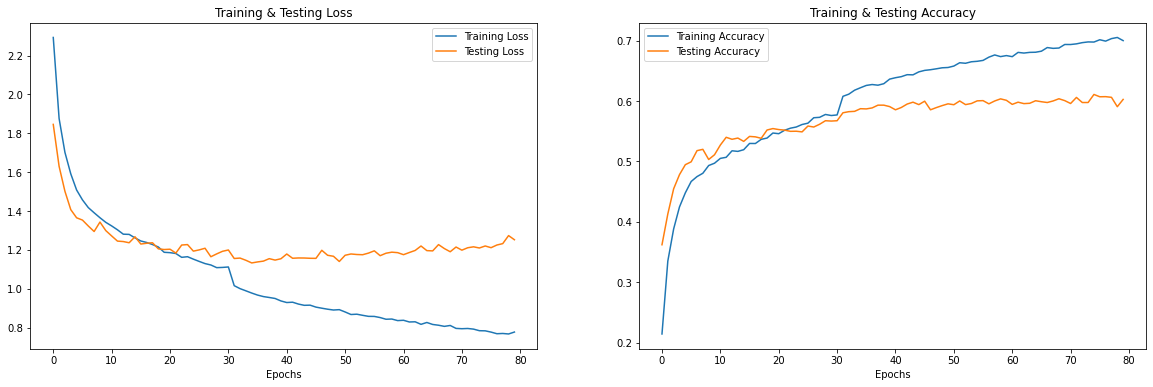

In [ ]:
print("Accuracy of our model on test data : " , model1d.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(80)]
fig , ax = plt.subplots(1,2)
train_acc = history1d.history['accuracy']
train_loss = history1d.history['loss']
test_acc = history1d.history['val_accuracy']
test_loss = history1d.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data
pred_test = model1d.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels   Actual Labels
0       female_sad  female_disgust
1   female_neutral  female_neutral
2      female_fear     female_fear
3        male_fear      male_angry
4      female_fear     female_fear
5       female_sad  female_disgust
6     female_angry    female_angry
7   female_disgust  female_disgust
8     male_neutral    male_disgust
9     male_neutral    male_neutral

### Model Evaluation

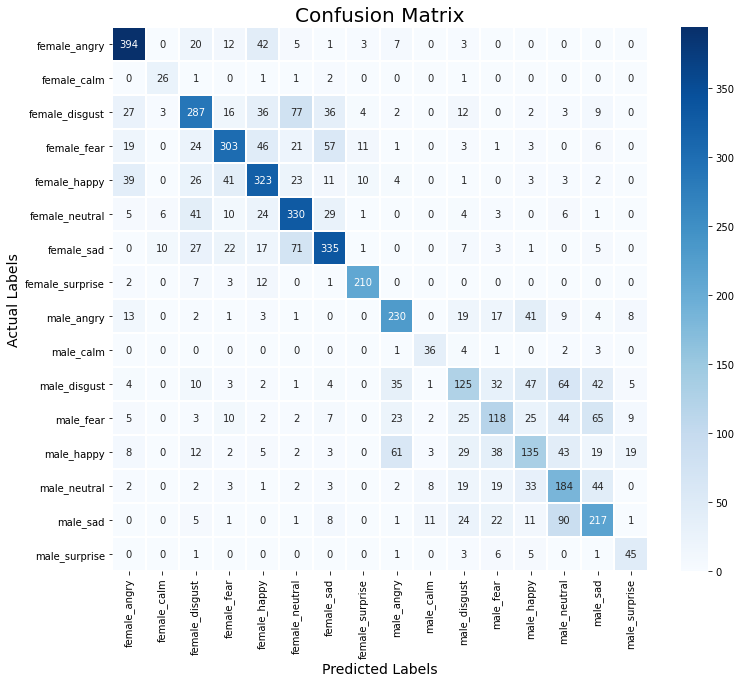

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

   female_angry       0.76      0.81      0.78       487
    female_calm       0.58      0.81      0.68        32
 female_disgust       0.61      0.56      0.58       514
    female_fear       0.71      0.61      0.66       495
   female_happy       0.63      0.66      0.65       486
 female_neutral       0.61      0.72      0.66       460
     female_sad       0.67      0.67      0.67       499
female_surprise       0.88      0.89      0.88       235
     male_angry       0.62      0.66      0.64       348
      male_calm       0.59      0.77      0.67        47
   male_disgust       0.45      0.33      0.38       375
      male_fear       0.45      0.35      0.39       340
     male_happy       0.44      0.36      0.39       379
   male_neutral       0.41      0.57      0.48       322
       male_sad       0.52      0.55      0.54       392
  male_surprise       0.52      0.73      0.60        62

       accuracy              

- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 61% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.

#### Gender Accuracy

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

0.9579755161702905


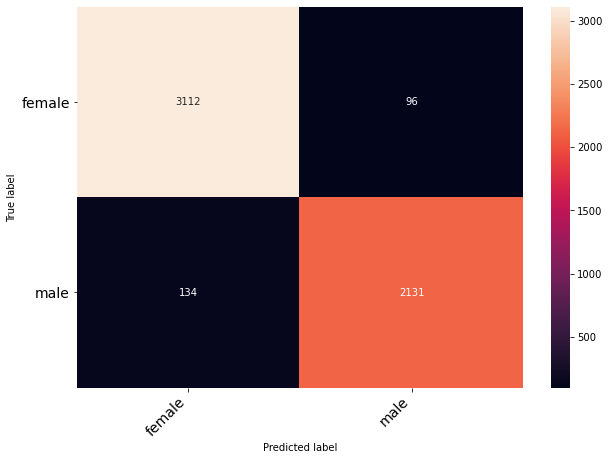

In [ ]:
modidf = df.copy()
modidf["actualvalues"] = df["Actual Labels"].apply(lambda x : x.split("_")[0])

modidf["predictedvalues"] = df["Predicted Labels"].apply(lambda x : x.split("_")[0])

classes = modidf["actualvalues"].unique()
classes.sort()

# Confusion matrix
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names=classes)


In [ ]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.96      0.97      0.96      3208
        male       0.96      0.94      0.95      2265

    accuracy                           0.96      5473
   macro avg       0.96      0.96      0.96      5473
weighted avg       0.96      0.96      0.96      5473



The model is very good at predicting the gender of the speaker

#### Emotion Accuracy

0.6175771971496437


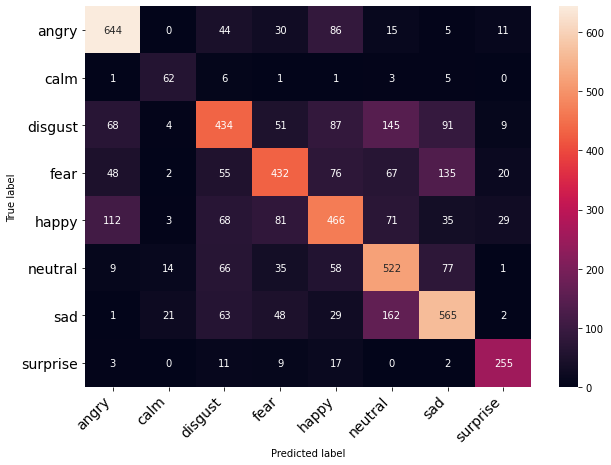

In [ ]:
modidf = df.copy()
modidf["actualvalues"] = df["Actual Labels"].apply(lambda x : x.split("_")[1])

modidf["predictedvalues"] = df["Predicted Labels"].apply(lambda x : x.split("_")[1])

classes = modidf["actualvalues"].unique()
classes.sort()

# Confusion matrix
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names=classes)


In [ ]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.73      0.77      0.75       835
        calm       0.58      0.78      0.67        79
     disgust       0.58      0.49      0.53       889
        fear       0.63      0.52      0.57       835
       happy       0.57      0.54      0.55       865
     neutral       0.53      0.67      0.59       782
         sad       0.62      0.63      0.63       891
    surprise       0.78      0.86      0.82       297

    accuracy                           0.62      5473
   macro avg       0.63      0.66      0.64      5473
weighted avg       0.62      0.62      0.61      5473



Model accuracy for just the emotions is 0.6. This seems low, but the random odds of predicting the emotion correct is 1/8 = 0.125, which in comparison is much lower. Hence, the model is performing well on the emotion prediction as well.